Loading model from disk...
Model loaded.
Loading data...
Preparing time slices...


/tmp/ipykernel_7352/3190413971.py:19: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['YearMonth'] = df['Date'].dt.to_period('M')


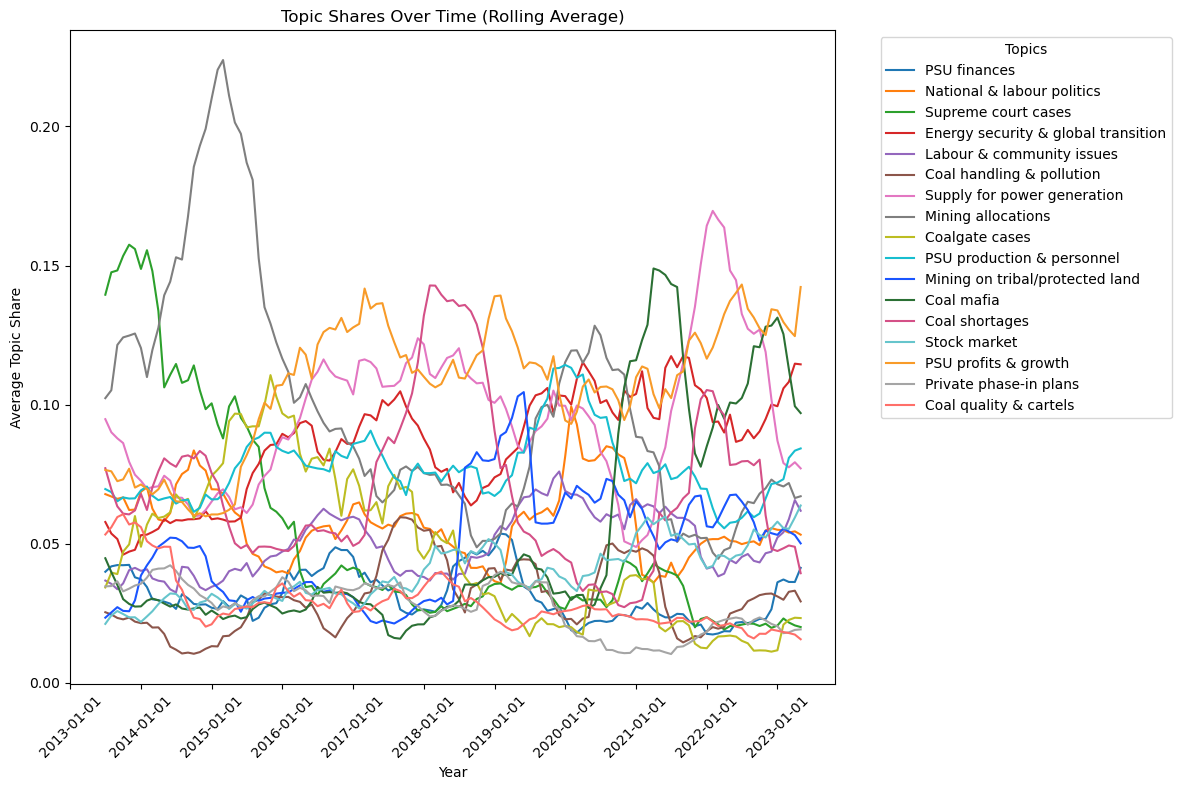

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd

# Load my model from disk
print("Loading model from disk...")
with open('dtm_model5.pkl', 'rb') as file:
    model = pickle.load(file)
print("Model loaded.")

# Load my preprocessed dataset
print("Loading data...")
df = pd.read_csv('/mnt/c/Users/arnea/OneDrive/Desktop/Thesis/Work/Python/df_preprocessedv7.csv')
df['Date'] = pd.to_datetime(df['Date'])

# Prepare timestamps for monthly time slices
print("Preparing time slices...")
df['YearMonth'] = df['Date'].dt.to_period('M')
timestamps = df['YearMonth'].dt.strftime('%Y-%m').unique().tolist()
time_slices = [df['YearMonth'].value_counts()[period] for period in sorted(df['YearMonth'].unique())]

num_topics = 17
topic_shares_over_time = np.zeros((len(time_slices), num_topics))

topic_names = {
    0: "PSU finances",
    1: "National & labour politics",
    2: "Supreme court cases",
    3: "Energy security & global transition",
    4: "Labour & community issues",
    5: "Coal handling & pollution",
    6: "Supply for power generation",
    7: "Mining allocations",
    8: "Coalgate cases",
    9: "PSU production & personnel",
    10: "Mining on tribal/protected land",
    11: "Coal mafia",
    12: "Coal shortages",
    13: "Stock market",
    14: "PSU profits & growth",
    15: "Private phase-in plans",
    16: "Coal quality & cartels",
}

# Defining a custom color palette so there are 17 different colors
colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#1a55FF', '#2b7034', '#d45087', '#66c5cc', '#f89b29',
    '#a5a5a5', '#ff6f69'
]

current_document = 0
for time_slice_index, num_docs in enumerate(time_slices):
    for _ in range(num_docs):
        topic_shares_over_time[time_slice_index, :] += model.gamma_[current_document, :]
        current_document += 1
    
    # Normalize by number of documents to get the average topic distribution for this time slice
    topic_shares_over_time[time_slice_index, :] /= num_docs

# Generate date range from January 2013 to October 2023
dates = pd.date_range(start='2013-01-01', periods=len(time_slices), freq='MS')

# Plotting each topic's development over time with rolling average
plt.figure(figsize=(12, 8))
for topic_idx in range(num_topics):
    rolling_avg = pd.Series(topic_shares_over_time[:, topic_idx]).rolling(window=12, center=True).mean()
    plt.plot(dates, rolling_avg, label=topic_names[topic_idx], color=colors[topic_idx])

plt.title('Topic Shares Over Time (Rolling Average)')
plt.xlabel('Year')
plt.ylabel('Average Topic Share')

plt.xticks(pd.date_range(start=dates[0], end=dates[-1], freq='YS'), rotation=45)

plt.legend(title='Topics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.savefig('/mnt/c/Users/arnea/OneDrive/Desktop/Thesis/Work/Python/topic_shares_over_time.png')
plt.show()

In [5]:
import numpy as np
import pickle
import pandas as pd

# Load the DTM model from disk
with open('dtm_model5.pkl', 'rb') as file:
    model = pickle.load(file)

num_topics = 17
num_words = 300 
num_time_slices = len(model.time_slices)

# Define my custom topic names
topic_names = {
    0: "PSU finances",
    1: "National & labour politics",
    2: "Supreme court cases",
    3: "Energy security & global transition",
    4: "Labour & community issues",
    5: "Coal handling & pollution",
    6: "Supply for power generation",
    7: "Mining allocations",
    8: "Coalgate cases",
    9: "PSU production & personnel",
    10: "Mining on tribal/protected land",
    11: "Coal mafia",
    12: "Coal shortages",
    13: "Stock market",
    14: "PSU profits & growth",
    15: "Private phase-in plans",
    16: "Coal quality & cartels",
}

# Initialize the dictionary to store word probabilities for each topic
topic_word_distributions = [{} for _ in range(num_topics)]

# Collect word distributions per topic across all time slices
for topic_idx in range(num_topics):
    for time_slice_idx in range(num_time_slices):
        topic_dist = model.show_topic(topic_idx, time=time_slice_idx, num_words=num_words)
        for prob, word in topic_dist:
            if word in topic_word_distributions[topic_idx]:
                topic_word_distributions[topic_idx][word] += prob
            else:
                topic_word_distributions[topic_idx][word] = prob

    # Normalize probabilities by the number of time slices to get the average probability
    for word in topic_word_distributions[topic_idx]:
        topic_word_distributions[topic_idx][word] /= num_time_slices

# Find the top 300 FREX words per topic based on their average probabilities
top_fre_words_per_topic = []
for dist in topic_word_distributions:
    # Sort words based on probabilities in descending order
    sorted_words = sorted(dist.items(), key=lambda x: x[1], reverse=True)
    top_fre_words = sorted_words[:300]  # Get the top 300 words
    top_fre_words_per_topic.append(top_fre_words)

# Print out the top FREX words for each topic using topic names
for idx, words in enumerate(top_fre_words_per_topic):
    print(f"{topic_names[idx]}:")
    for word, prob in words:
        print(f"{word} ({prob:.4f})", end=", ")
    print("\n")

# Create a list of dictionaries for DataFrame conversion
data = []
for idx, words in enumerate(top_fre_words_per_topic):
    for word, prob in words:
        data.append({"Topic": topic_names[idx], "Word": word, "Probability": prob})

# Convert to DataFrame
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv('top_fre_words_per_topic.csv', index=False)

print("Saved top FREX words to 'top_fre_words_per_topic_model5.csv'")


/home/arne/miniconda3/envs/dtm2/lib/python3.8/site-packages/gensim/models/wrappers/dtmmodel.py:498: UserWarning: The parameter `num_words` is deprecated, will be removed in 4.0.0, use `topn` instead.
  warnings.warn("The parameter `num_words` is deprecated, will be removed in 4.0.0, use `topn` instead.")


PSU finances:
compani (0.0413), share (0.0374), govern (0.0252), stake (0.0184), sale (0.0174), dividend (0.0172), cil (0.0135), offer (0.0119), price (0.0115), fund (0.0093), equiti (0.0092), investor (0.0085), public (0.0080), board (0.0075), cash (0.0074), sell (0.0071), financi (0.0071), disinvest (0.0070), hold (0.0069), market (0.0068), employe (0.0066), capit (0.0066), approv (0.0065), payment (0.0064), divest (0.0063), pay (0.0063), paid (0.0062), rais (0.0061), psu (0.0059), manag (0.0058), current (0.0057), buyback (0.0056), retail (0.0056), asset (0.0054), invest (0.0054), salari (0.0054), sharehold (0.0053), valu (0.0052), profit (0.0051), percent (0.0050), own (0.0049), revenu (0.0047), stock (0.0047), plan (0.0045), close (0.0045), target (0.0045), propos (0.0044), centr (0.0044), list (0.0043), announc (0.0043), held (0.0043), tax (0.0042), addit (0.0042), miner (0.0042), back (0.0042), buy (0.0041), decid (0.0040), hike (0.0039), exchang (0.0039), issu (0.0039), date (0

In [6]:
import numpy as np
import pickle
import pandas as pd

# Load the DTM model from disk
with open('dtm_model5.pkl', 'rb') as file:
    model = pickle.load(file)

num_topics = 17
num_words = 300 
num_time_slices = len(model.time_slices)

# Define custom topic names
topic_names = {
    0: "PSU finances",
    1: "National & labour politics",
    2: "Supreme court cases",
    3: "Energy security & global transition",
    4: "Labour & community issues",
    5: "Coal handling & pollution",
    6: "Supply for power generation",
    7: "Mining allocations",
    8: "Coalgate cases",
    9: "PSU production & personnel",
    10: "Mining on tribal/protected land",
    11: "Coal mafia",
    12: "Coal shortages",
    13: "Stock market",
    14: "PSU profits & growth",
    15: "Private phase-in plans",
    16: "Coal quality & cartels",
}

# Initialize the list to store word probabilities for each topic and each time slice
topic_time_slice_word_distributions = []

# Collect word distributions per topic per time slice
for time_slice_idx in range(num_time_slices):
    time_slice_distributions = []
    for topic_idx in range(num_topics):
        topic_dist = model.show_topic(topic_idx, time=time_slice_idx, num_words=num_words)
        top_words = [(prob, word) for prob, word in topic_dist]
        time_slice_distributions.append(top_words)
    topic_time_slice_word_distributions.append(time_slice_distributions)

# Create a list of dictionaries for DataFrame conversion
data_per_time_slice = []
for time_slice_idx, distributions in enumerate(topic_time_slice_word_distributions):
    for topic_idx, words in enumerate(distributions):
        for prob, word in words:
            data_per_time_slice.append({
                "Time Slice": time_slice_idx,
                "Topic": topic_names[topic_idx],
                "Word": word,
                "Probability": prob
            })

# Convert to DataFrame
df_per_time_slice = pd.DataFrame(data_per_time_slice)

# Save the DataFrame to a CSV file
df_per_time_slice.to_csv('top_fre_words_per_topic_per_time_slice_model5.csv', index=False)

print("Saved top FREX words per time slice to 'top_fre_words_per_topic_per_time_slice.csv'")

Saved top FREX words per time slice to 'top_fre_words_per_topic_per_time_slice.csv'


In [15]:
import pandas as pd
import numpy as np
import pickle
from docx import Document

# Load the DTM model from disk
print("Loading model from disk...")
with open('dtm_model5.pkl', 'rb') as file:
    model = pickle.load(file)
print("Model loaded.")

# Load the preprocessed dataset
print("Loading data...")
df = pd.read_csv('/mnt/c/Users/arnea/OneDrive/Desktop/Thesis/Work/Python/df_preprocessedv7.csv')
df['Date'] = pd.to_datetime(df['Date'])

# Prepare timestamps for monthly time slices
print("Preparing time slices...")
df['YearMonth'] = df['Date'].dt.to_period('M')
timestamps = df['YearMonth'].dt.strftime('%Y-%m').unique().tolist()
time_slices = [df['YearMonth'].value_counts()[period] for period in sorted(df['YearMonth'].unique())]
date_labels = [period.strftime('%B %Y') for period in sorted(df['YearMonth'].unique())]
unique_years = df['Date'].dt.year.unique()

num_topics = 17
topic_names = {
    0: "PSU finances",
    1: "National & labour politics",
    2: "Supreme court cases",
    3: "Energy security & global transition",
    4: "Labour & community issues",
    5: "Coal handling & pollution",
    6: "Supply for power generation",
    7: "Mining allocations",
    8: "Coalgate cases",
    9: "PSU production & personnel",
    10: "Mining on tribal/protected land",
    11: "Coal mafia",
    12: "Coal shortages",
    13: "Stock market",
    14: "PSU profits & growth",
    15: "Private phase-in plans",
    16: "Coal quality & cartels",
}

# Create new Word documents
document_ts = Document()
document_ts.add_heading('Document per Time Slice', level=1)
document_year = Document()
document_year.add_heading('Document per Year', level=1)

# Initialize to store maximum gamma values and corresponding articles
max_gamma_ts = np.full((len(time_slices), num_topics), -np.inf)
max_docs_ts = np.empty((len(time_slices), num_topics), dtype=object)
max_gamma_yr = np.full((len(date_labels), num_topics), -np.inf)
max_docs_yr = np.empty((len(date_labels), num_topics), dtype=object)

# Process documents
start_index = 0
for time_slice_index, num_docs in enumerate(time_slices):
    year_index = time_slice_index // 12
    end_index = min(start_index + num_docs, model.gamma_.shape[0])
    for i in range(start_index, end_index): 
        for topic_idx in range(num_topics):
            gamma = model.gamma_[i, topic_idx]
            if gamma > max_gamma_ts[time_slice_index, topic_idx]:
                max_gamma_ts[time_slice_index, topic_idx] = gamma
                max_docs_ts[time_slice_index, topic_idx] = df.iloc[i]
            if gamma > max_gamma_yr[year_index, topic_idx]:
                max_gamma_yr[year_index, topic_idx] = gamma
                max_docs_yr[year_index, topic_idx] = df.iloc[i]
    start_index += num_docs

# Write to documents by topic
for topic_idx in range(num_topics):
    document_ts.add_heading(f'Topic: {topic_names[topic_idx]}', level=2)
    for time_slice_index in range(len(time_slices)):
        doc = max_docs_ts[time_slice_index, topic_idx]
        if doc is not None:
            date_str = doc['Date'].strftime('%Y-%m-%d')
            document_ts.add_heading(f'Date: {date_str}', level=3) 
            document_ts.add_paragraph(f"Title: {doc['Title']}")
            document_ts.add_paragraph(f"Publication: {doc['Publication']}")
            document_ts.add_paragraph(f"Author: {doc['Byline']}")
            document_ts.add_paragraph(f"Article ID: {doc['Unnamed: 0']}")
            document_ts.add_paragraph(doc['Article_Text'])

    document_year.add_heading(f'Topic: {topic_names[topic_idx]}', level=2)
    for year_index in range(len(unique_years)):
        doc = max_docs_yr[year_index, topic_idx]
        if doc is not None:
            document_year.add_heading(f'Year: {unique_years[year_index]}', level=3)
            document_year.add_paragraph(f"Title: {doc['Title']}")
            document_year.add_paragraph(f"Publication: {doc['Publication']}")
            document_year.add_paragraph(f"Author: {doc['Byline']}")
            document_year.add_paragraph(f"Article ID: {doc['Unnamed: 0']}")
            document_year.add_paragraph(doc['Article_Text'])

# Save the documents
document_ts.save('Documents_Per_Time_Slice_by_Topic.docx')
document_year.save('Documents_Per_Year_by_Topic.docx')
print("Documents saved.")

Loading model from disk...
Model loaded.
Loading data...
Preparing time slices...


/tmp/ipykernel_72/67558418.py:19: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['YearMonth'] = df['Date'].dt.to_period('M')


Documents saved.


In [49]:
import pandas as pd
import numpy as np
import pickle
from docx import Document
from openpyxl import Workbook
from openpyxl.styles import Alignment, Font, PatternFill
from openpyxl.utils import get_column_letter

# Load the DTM model from disk
print("Loading model from disk...")
with open('dtm_model5.pkl', 'rb') as file:
    model = pickle.load(file)
print("Model loaded.")

# Load the preprocessed dataset
print("Loading data...")
df = pd.read_csv('/mnt/c/Users/arnea/OneDrive/Desktop/Thesis/Work/Python/df_preprocessedv7.csv')
df['Date'] = pd.to_datetime(df['Date'])

# Prepare timestamps for monthly time slices
print("Preparing time slices...")
df['YearMonth'] = df['Date'].dt.to_period('M')
timestamps = df['YearMonth'].dt.strftime('%Y-%m').unique().tolist()
time_slices = [df['YearMonth'].value_counts()[period] for period in sorted(df['YearMonth'].unique())]
date_labels = [period.strftime('%B %Y') for period in sorted(df['YearMonth'].unique())]

num_topics = 17
topic_names = {
    0: "PSU finances",
    1: "National & labour politics",
    2: "Supreme court cases",
    3: "Energy security & global transition",
    4: "Labour & community issues",
    5: "Coal handling & pollution",
    6: "Supply for power generation",
    7: "Mining allocations",
    8: "Coalgate cases",
    9: "PSU production & personnel",
    10: "Mining on tribal/protected land",
    11: "Coal mafia",
    12: "Coal shortages",
    13: "Stock market",
    14: "PSU profits & growth",
    15: "Private phase-in plans",
    16: "Coal quality & cartels",
}

# Initialize Excel data collection
excel_data = []

# Initialize to store maximum gamma values and corresponding articles
max_gamma_yr = {year: {topic: -np.inf for topic in topic_names.keys()} for year in range(df['Date'].dt.year.min(), df['Date'].dt.year.max() + 1)}
max_docs_yr = {year: {topic: None for topic in topic_names.keys()} for year in range(df['Date'].dt.year.min(), df['Date'].dt.year.max() + 1)}

# Process documents
for i in range(len(df)):
    year = df.at[i, 'Date'].year
    for topic_idx in range(num_topics):
        gamma = model.gamma_[i, topic_idx]
        if gamma > max_gamma_yr[year][topic_idx]:
            max_gamma_yr[year][topic_idx] = gamma
            max_docs_yr[year][topic_idx] = df.iloc[i]

# Document creation for each topic and year
document_year = Document()
document_year.add_heading('Document per Year by Topic', level=1)
for topic_idx, topic_name in topic_names.items():
    document_year.add_heading(f'Topic: {topic_name}', level=2)
    for year, doc in max_docs_yr.items():
        if doc[topic_idx] is not None:
            document_year.add_heading(f'Year: {year}', level=3)
            document_year.add_paragraph(f"Title: {doc[topic_idx]['Title']}")
            document_year.add_paragraph(f"Publication: {doc[topic_idx]['Publication']}")
            document_year.add_paragraph(f"Author: {doc[topic_idx]['Byline']}")
            document_year.add_paragraph(f"Article ID: {doc[topic_idx]['Unnamed: 0']}")
            document_year.add_paragraph(doc[topic_idx]['Article_Text'])
            
            excel_data.append({
                "Article ID": doc[topic_idx]['Unnamed: 0'],
                "Title": doc[topic_idx]['Title'],
                "Year": year,
                "Publication": doc[topic_idx]['Publication'],
                "Author(s)": doc[topic_idx]['Byline'],
                "Article text": doc[topic_idx]['Article_Text'],
                "Topic number": topic_idx,
                "Key argument or narrative": "",
                "Representative quote": "",
                "Actor perspective": "",
                "Actor category": "",
                "Notes": ""
            })# Process documents


# Save the document
document_year.save('Documents_Per_Year_by_Topic.docx')
print("Document saved.")

# Excel handling
wb = Workbook()
ws = wb.active
headers = ["Article ID", "Title", "Year", "Publication", "Author(s)", "Article text", "Topic number",
           "Key argument or narrative", "Representative quote", "Actor perspective", "Actor category", "Notes"]
header_row = ws.append(headers)

# Set superheadings
ws.merge_cells('A1:G1')
ws.merge_cells('H1:I1')
ws.merge_cells('J1:K1')
ws['A1'] = "Article metadata"
ws['H1'] = "Narratives"
ws['J1'] = "Actors"
ws['L1'] = "Notes"

# Format superheadings
for col in range(1, len(headers)+1):
    cell = ws.cell(row=1, column=col)
    cell.font = Font(bold=True, color="FFFFFF")
    cell.fill = PatternFill("solid", fgColor="4F81BD")
    cell.alignment = Alignment(horizontal="center")
    ws.column_dimensions[get_column_letter(col)].width = 20

# Fill data into Excel
for data in excel_data:
    ws.append([data[header] for header in headers])

# Save Excel file
excel_path = 'Article_Metadata_and_Analysis.xlsx'
wb.save(excel_path)
print(f"Excel file saved to {excel_path}")

Loading model from disk...
Model loaded.
Loading data...
Preparing time slices...


/tmp/ipykernel_7352/55933809.py:22: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['YearMonth'] = df['Date'].dt.to_period('M')


Document saved.
Excel file saved to Article_Metadata_and_Analysis.xlsx


In [5]:
import pandas as pd
import numpy as np
import pickle
from docx import Document
from openpyxl import Workbook
from openpyxl.styles import Alignment, Font, PatternFill
from openpyxl.utils import get_column_letter

# Load the DTM model from disk
print("Loading model from disk...")
with open('dtm_model5.pkl', 'rb') as file:
    model = pickle.load(file)
print("Model loaded.")

# Load the preprocessed dataset
print("Loading data...")
df = pd.read_csv('/mnt/c/Users/arnea/OneDrive/Desktop/Thesis/Work/Python/df_preprocessedv7.csv')
df['Date'] = pd.to_datetime(df['Date'])

# Prepare timestamps for monthly time slices
print("Preparing time slices...")
df['YearMonth'] = df['Date'].dt.to_period('M')
timestamps = df['YearMonth'].dt.strftime('%Y-%m').unique().tolist()
time_slices = [df['YearMonth'].value_counts()[period] for period in sorted(df['YearMonth'].unique())]
date_labels = [period.strftime('%B %Y') for period in sorted(df['YearMonth'].unique())]

document_year = Document()
document_year.add_heading('Document per Year by Topic', level=1)

num_topics = 17
topic_names = {
    0: "PSU finances",
    1: "National & labour politics",
    2: "Supreme court cases",
    3: "Energy security & global transition",
    4: "Labour & community issues",
    5: "Coal handling & pollution",
    6: "Supply for power generation",
    7: "Mining allocations",
    8: "Coalgate cases",
    9: "PSU production & personnel",
    10: "Mining on tribal/protected land",
    11: "Coal mafia",
    12: "Coal shortages",
    13: "Stock market",
    14: "PSU profits & growth",
    15: "Private phase-in plans",
    16: "Coal quality & cartels",
}

# Initialize Excel data collection
excel_data = []

# Initialize to store maximum gamma values and corresponding articles
max_gamma_yr = {year: {topic: -np.inf for topic in topic_names.keys()} for year in range(df['Date'].dt.year.min(), df['Date'].dt.year.max() + 1)}
max_docs_yr = {year: {topic: None for topic in topic_names.keys()} for year in range(df['Date'].dt.year.min(), df['Date'].dt.year.max() + 1)}

# Process documents
for i in range(model.gamma_.shape[0]):
    year = df.at[i, 'Date'].year
    for topic_idx in range(num_topics):
        gamma = model.gamma_[i, topic_idx]
        if gamma > max_gamma_yr[year][topic_idx]:
            max_gamma_yr[year][topic_idx] = gamma
            max_docs_yr[year][topic_idx] = df.iloc[i]

# Document creation for each topic and year
for topic_idx, topic_name in topic_names.items():
    for year, doc in max_docs_yr.items():
        if doc[topic_idx] is not None:
            document_year.add_paragraph(f"Date: {doc[topic_idx]['Date'].strftime('%Y-%m-%d')}")  # Use full date
            excel_data.append({
                "Article ID": doc[topic_idx]['Unnamed: 0'],
                "Title": doc[topic_idx]['Title'],
                "Date": doc[topic_idx]['Date'].strftime('%Y-%m-%d'),  # Changed from Year to Date
                "Publication": doc[topic_idx]['Publication'],
                "Author(s)": doc[topic_idx]['Byline'],
                "Article text": doc[topic_idx]['Article_Text'],
                "Topic": topic_names[topic_idx],
                "Key argument or narrative": "",
                "Representative quote": "",
                "Actor perspective": "",
                "Actor category": "",
                "Notes": ""
            })

# Save the document
document_year.save('Documents_Per_Year_by_Topicv2.docx')
print("Document saved.")

# Excel handling
wb = Workbook()
ws = wb.active
headers = ["Article ID", "Title", "Date", "Publication", "Author(s)", "Article text", "Topic",
           "Key argument or narrative", "Representative quote", "Actor perspective", "Actor category", "Notes"]
header_row = ws.append(headers)

# Set superheadings
ws.merge_cells('A1:G1')
ws.merge_cells('H1:I1')
ws.merge_cells('J1:K1')
ws['A1'] = "Article metadata"
ws['H1'] = "Narratives"
ws['J1'] = "Actors"
ws['L1'] = "Notes"

# Format superheadings
for col in range(1, len(headers)+1):
    cell = ws.cell(row=1, column=col)
    cell.font = Font(bold=True, color="FFFFFF")
    cell.fill = PatternFill("solid", fgColor="4F81BD")
    cell.alignment = Alignment(horizontal="center")
    ws.column_dimensions[get_column_letter(col)].width = 20

# Fill data into Excel
for data in excel_data:
    ws.append([data[header] for header in headers])

# Save Excel file
excel_path = 'Article_Metadata_and_Analysis.xlsx'
wb.save(excel_path)
print(f"Excel file saved to {excel_path}")

Loading model from disk...
Model loaded.
Loading data...
Preparing time slices...
Document saved.


/tmp/ipykernel_72/2802637316.py:22: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['YearMonth'] = df['Date'].dt.to_period('M')


Excel file saved to Article_Metadata_and_Analysis.xlsx


/tmp/ipykernel_7352/1103443716.py:15: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['YearMonth'] = df['Date'].dt.to_period('M')


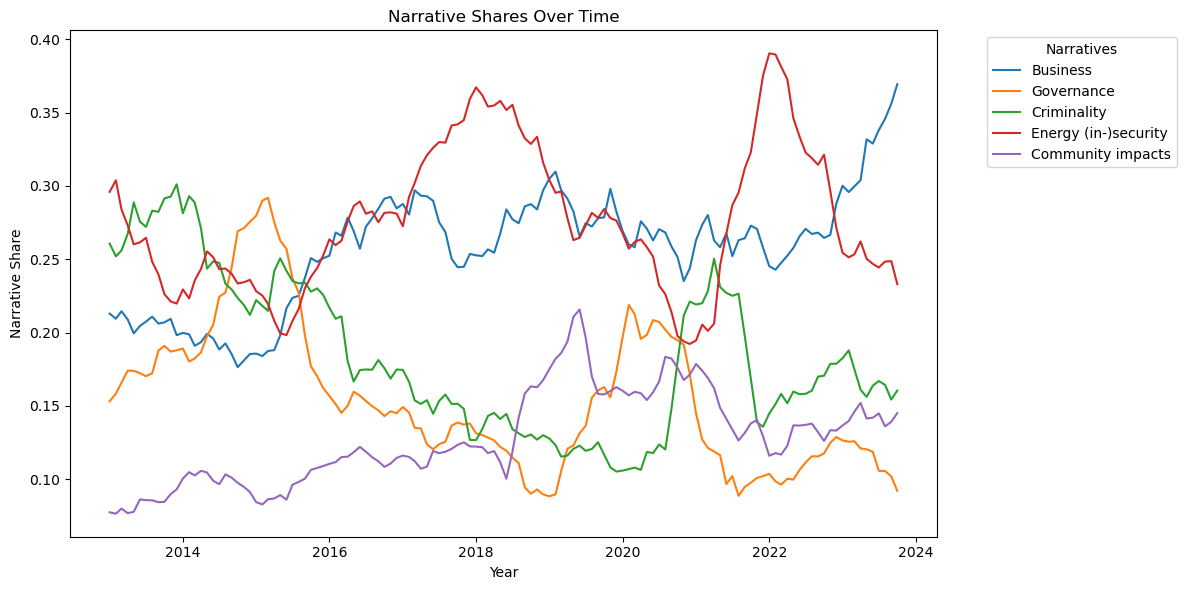

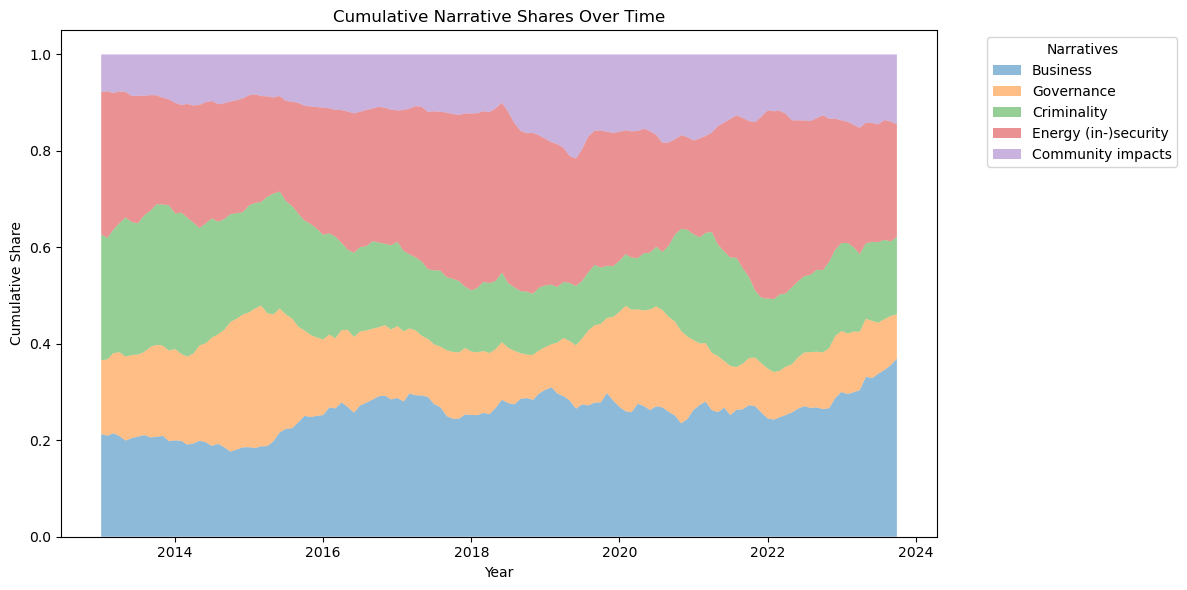

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

# Load the model from disk
with open('dtm_model5.pkl', 'rb') as file:
    model = pickle.load(file)

# Load my preprocessed dataset
df = pd.read_csv('/mnt/c/Users/arnea/OneDrive/Desktop/Thesis/Work/Python/df_preprocessedv7.csv')
df['Date'] = pd.to_datetime(df['Date'])

# Prepare timestamps for monthly time slices
df['YearMonth'] = df['Date'].dt.to_period('M')
timestamps = df['YearMonth'].dt.strftime('%Y-%m').unique().tolist()
time_slices = [df['YearMonth'].value_counts()[period] for period in sorted(df['YearMonth'].unique())]

# Define narrative mappings
narrative_mapping = {
    "Business": [0, 9, 13, 14],
    "Governance": [1,7],
    "Criminality": [2, 8, 11, 16],
    "Energy (in-)security": [3, 6, 12, 15],
    "Community impacts": [4, 5, 10]
}

# Colors for each narrative
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Initialize narrative shares
num_time_slices = len(time_slices)
narrative_shares = np.zeros((num_time_slices, len(narrative_mapping)))

current_document = 0
for time_slice_index, num_docs in enumerate(time_slices):
    for _ in range(num_docs):
        topic_distribution = model.gamma_[current_document, :]
        for narrative_idx, topics in enumerate(narrative_mapping.values()):
            narrative_shares[time_slice_index, narrative_idx] += topic_distribution[topics].sum()
        current_document += 1
    narrative_shares[time_slice_index, :] /= num_docs

# Rolling average calculation
rolling_narrative_shares = np.zeros_like(narrative_shares)
for i in range(len(narrative_mapping)):
    rolling_narrative_shares[:, i] = pd.Series(narrative_shares[:, i]).rolling(window=12, min_periods=1, center=True).mean()

# Generate date range from January 2013 to October 2023
dates = pd.date_range(start='2013-01-01', periods=len(time_slices), freq='MS')

# Combined Line Plot
plt.figure(figsize=(12, 6))
for idx, narrative in enumerate(narrative_mapping.keys()):
    plt.plot(dates, rolling_narrative_shares[:, idx], label=narrative, color=colors[idx])
plt.title('Narrative Shares Over Time')
plt.xlabel('Year')
plt.ylabel('Narrative Share')
plt.legend(title='Narratives', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('/mnt/c/Users/arnea/OneDrive/Desktop/Thesis/Work/Python/narrative_shares_over_time.png')
plt.show()

# Stacked Area Chart
plt.figure(figsize=(12, 6))
plt.stackplot(dates, rolling_narrative_shares.T, labels=list(narrative_mapping.keys()), colors=colors, alpha=0.5)
plt.title('Cumulative Narrative Shares Over Time')
plt.xlabel('Year')
plt.ylabel('Cumulative Share')
plt.legend(title='Narratives', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('/mnt/c/Users/arnea/OneDrive/Desktop/Thesis/Work/Python/cum_narrative_shares_over_time.png')
plt.show()

Loading model from disk...
Model loaded.
Loading data...
Preparing time slices...
Topic: PSU finances, Peak Year: 2018
Topic: National & labour politics, Peak Year: 2020
Topic: Supreme court cases, Peak Year: 2013
Topic: Energy security & global transition, Peak Year: 2021
Topic: Labour & community issues, Peak Year: 2021
Topic: Coal handling & pollution, Peak Year: 2021
Topic: Supply for power generation, Peak Year: 2022
Topic: Mining allocations, Peak Year: 2015
Topic: Coalgate cases, Peak Year: 2016
Topic: PSU production & personnel, Peak Year: 2020
Topic: Mining on tribal/protected land, Peak Year: 2019
Topic: Coal mafia, Peak Year: 2021
Topic: Coal shortages, Peak Year: 2018
Topic: Stock market, Peak Year: 2018
Topic: PSU profits & growth, Peak Year: 2023
Topic: Private phase-in plans, Peak Year: 2019
Topic: Coal quality & cartels, Peak Year: 2014


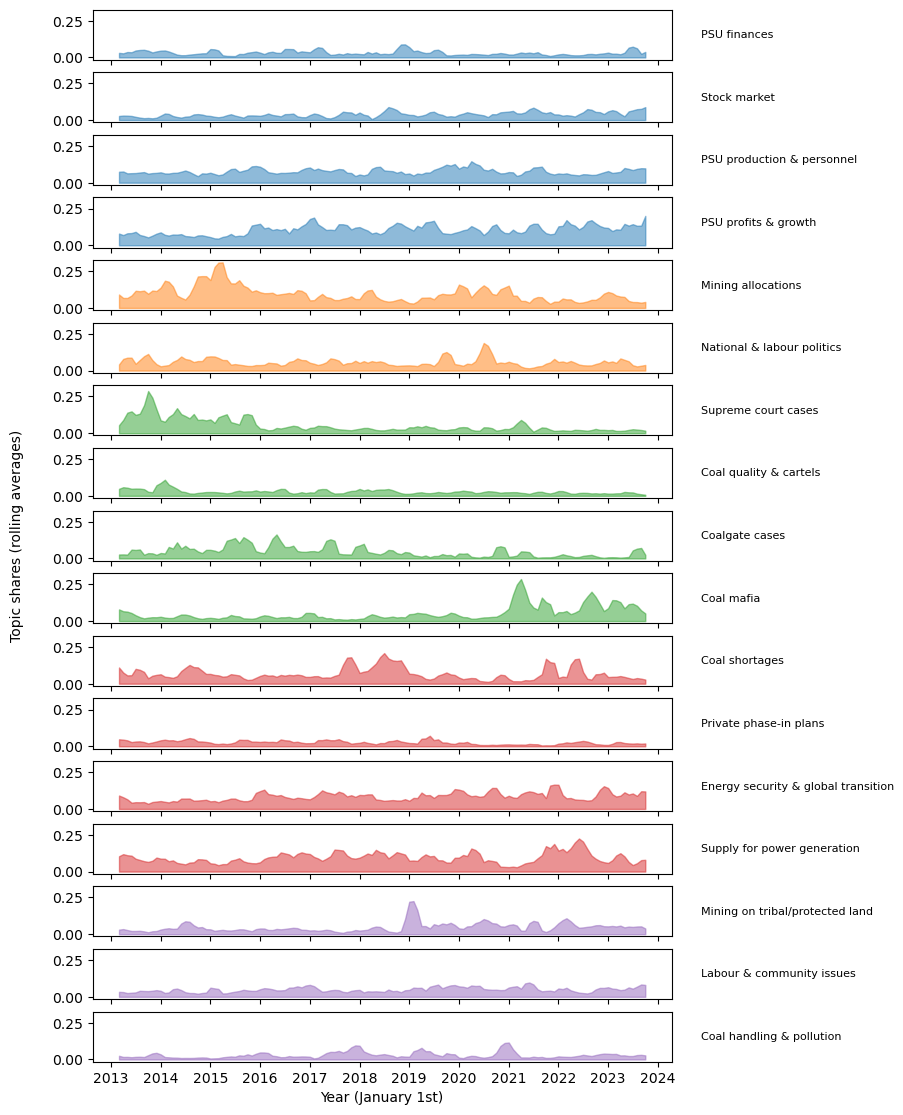

In [92]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pickle
import pandas as pd

# Load the model from disk
print("Loading model from disk...")
with open('dtm_model5.pkl', 'rb') as file:
    model = pickle.load(file)
print("Model loaded.")

# Load the preprocessed dataset
print("Loading data...")
df = pd.read_csv('/mnt/c/Users/arnea/OneDrive/Desktop/Thesis/Work/Python/df_preprocessedv7.csv')
df['Date'] = pd.to_datetime(df['Date'], utc=True).dt.tz_convert(None)

# Prepare timestamps for monthly time slices
print("Preparing time slices...")
df['YearMonth'] = df['Date'].dt.to_period('M')
time_slices = [df['YearMonth'].value_counts()[period] for period in sorted(df['YearMonth'].unique())]

# Define narrative mappings with topic indices and colors
narrative_mapping = {
    "Business": ([0, 9, 13, 14], '#1f77b4'),
    "Governance": ([1, 7], '#ff7f0e'),
    "Criminality": ([2, 8, 11, 16], '#2ca02c'),
    "Energy (in-)security": ([3, 6, 12, 15], '#d62728'),
    "Community impacts": ([4, 5, 10], '#9467bd')
}

# Topic names
topic_names = {
    0: "PSU finances",
    1: "National & labour politics",
    2: "Supreme court cases",
    3: "Energy security & global transition",
    4: "Labour & community issues",
    5: "Coal handling & pollution",
    6: "Supply for power generation",
    7: "Mining allocations",
    8: "Coalgate cases",
    9: "PSU production & personnel",
    10: "Mining on tribal/protected land",
    11: "Coal mafia",
    12: "Coal shortages",
    13: "Stock market",
    14: "PSU profits & growth",
    15: "Private phase-in plans",
    16: "Coal quality & cartels",
}

# Calculate topic shares over time
num_topics = len(topic_names)
topic_shares_over_time = np.zeros((len(time_slices), num_topics))

current_document = 0
for time_slice_index, num_docs in enumerate(time_slices):
    for _ in range(num_docs):
        topic_shares_over_time[time_slice_index, :] += model.gamma_[current_document, :]
        current_document += 1

    # Normalize by number of documents to get the average topic distribution for this time slice
    topic_shares_over_time[time_slice_index, :] /= num_docs

# Rolling averages
window_size = 3  # 12 months for 1 year
rolling_topic_shares = np.array([pd.Series(topic_shares_over_time[:, i]).rolling(window=window_size).mean()
                                 for i in range(num_topics)]).T

# Generate date range from January 2013 to October 2023
dates = pd.date_range(start='2013-01-01', periods=len(time_slices), freq='MS')

# Determine the peak year for each topic
peak_years = {}
for topic_idx, topic_name in topic_names.items():
    topic_data = rolling_topic_shares[:, topic_idx]
    # Find the index of the maximum value ignoring NaNs
    peak_index = np.nanargmax(topic_data)
    peak_years[topic_idx] = dates[peak_index].year if peak_index >= 0 else None

# Now print the peak year for each topic
for topic_idx, year in peak_years.items():
    if year is not None:
        print(f"Topic: {topic_names[topic_idx]}, Peak Year: {year}")
    else:
        print(f"Topic: {topic_names[topic_idx]} has no peak year due to insufficient data.")

# Order topics by narratives and by peak year within each narrative
ordered_topics = []
for narrative, (topics, _) in narrative_mapping.items():
    topics_by_peak = sorted(topics, key=lambda t: peak_years[t])
    ordered_topics.extend(topics_by_peak)

# Plotting
fig_width = 8.27  # A4 width in inches
fig_height = 11.69  # A4 height in inches
fig, axes = plt.subplots(nrows=num_topics, ncols=1, figsize=(fig_width, fig_height), sharex=True, sharey=True)
plt.subplots_adjust(left=0.15, right=0.85, top=0.95, bottom=0.05, hspace=0.25)

for idx, topic_idx in enumerate(ordered_topics):
    ax = axes[idx]
    narrative_color = topic_to_narrative_color[topic_idx]
    data = rolling_topic_shares[:, topic_idx]
    ax.fill_between(dates, 0, data, label=topic_names[topic_idx], color=narrative_color, alpha=0.5)
    ax.text(1.05, 0.5, topic_names[topic_idx], transform=ax.transAxes, va='center', ha='left', fontsize=8)

    # Setting the x-axis for years only
    ax.xaxis.set_major_locator(mdates.YearLocator(1))  # Set major ticks to every second year
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Show only the year

# Set common x-axis labels
axes[-1].set_xlabel('Year (January 1st)')

# Set common y-axis label
fig.text(0.05, 0.5, 'Topic shares (rolling averages)', va='center', rotation='vertical', fontsize=10)

# Save the figure
plt.savefig('/mnt/c/Users/arnea/OneDrive/Desktop/Thesis/Work/Python/topic_shares_rolling_average_by_narrative.png', bbox_inches='tight', dpi=300)
plt.show()

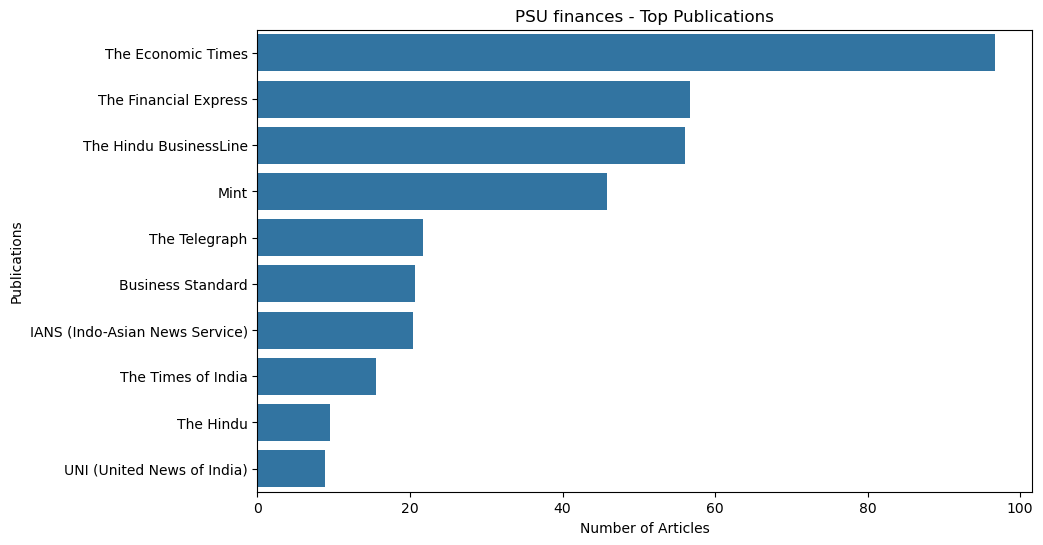

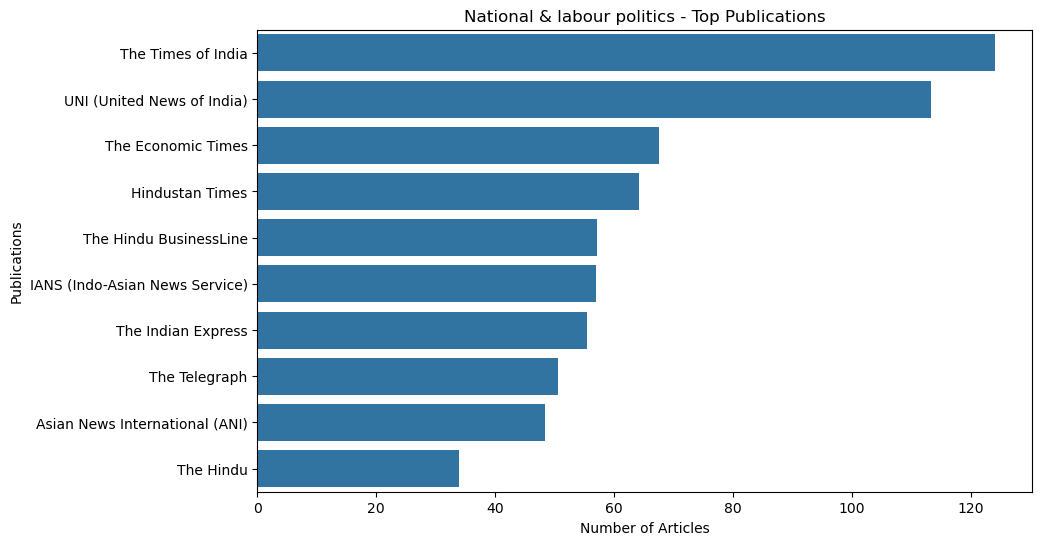

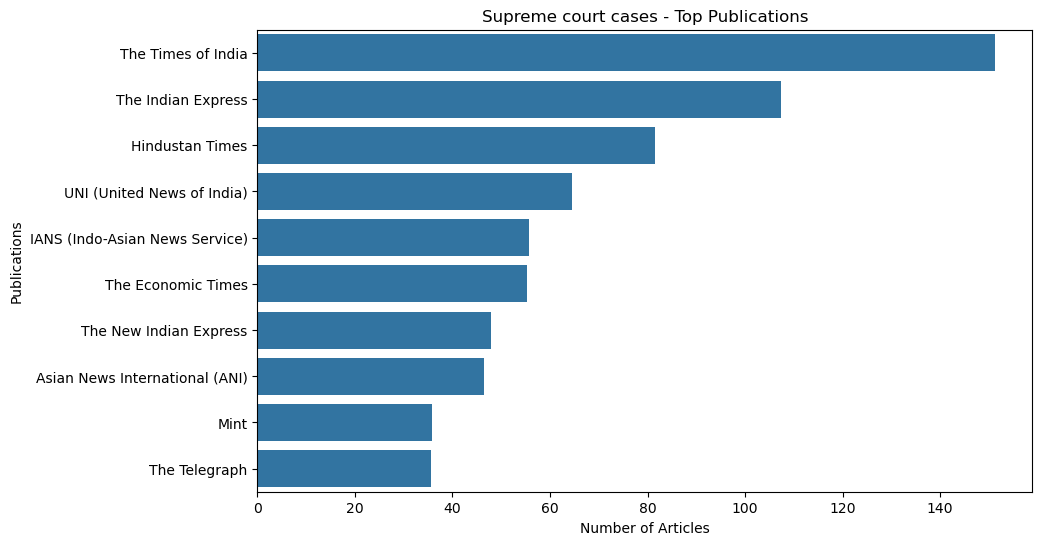

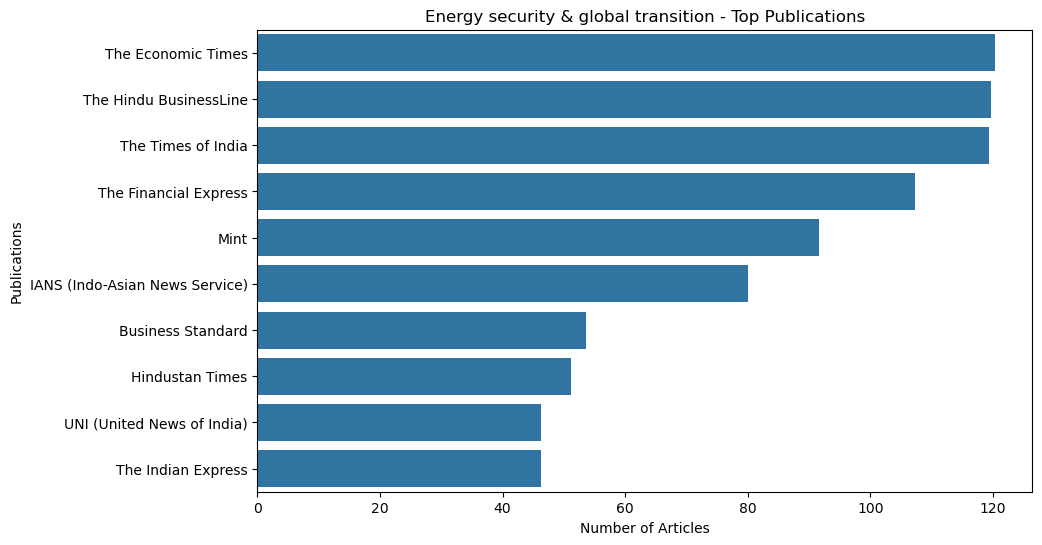

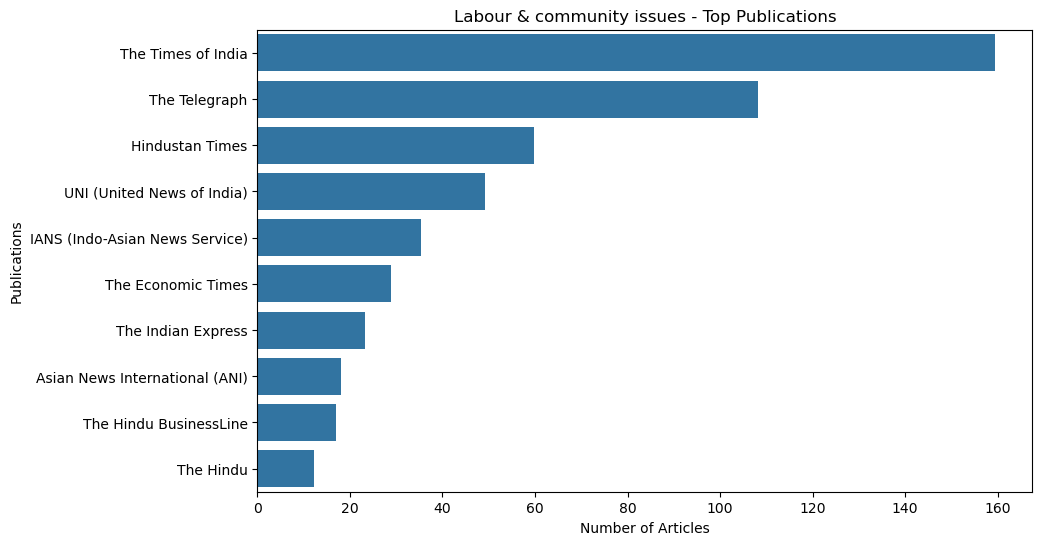

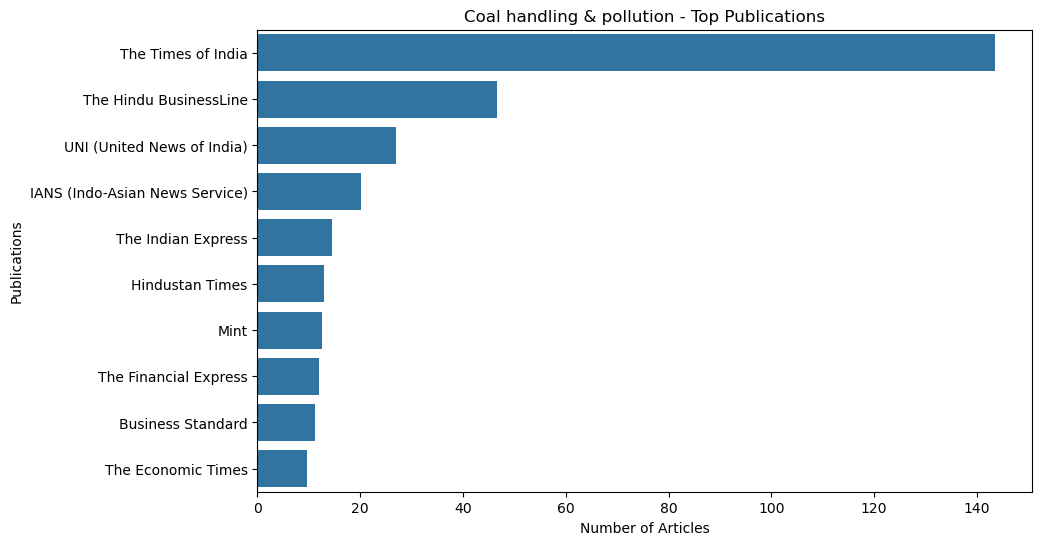

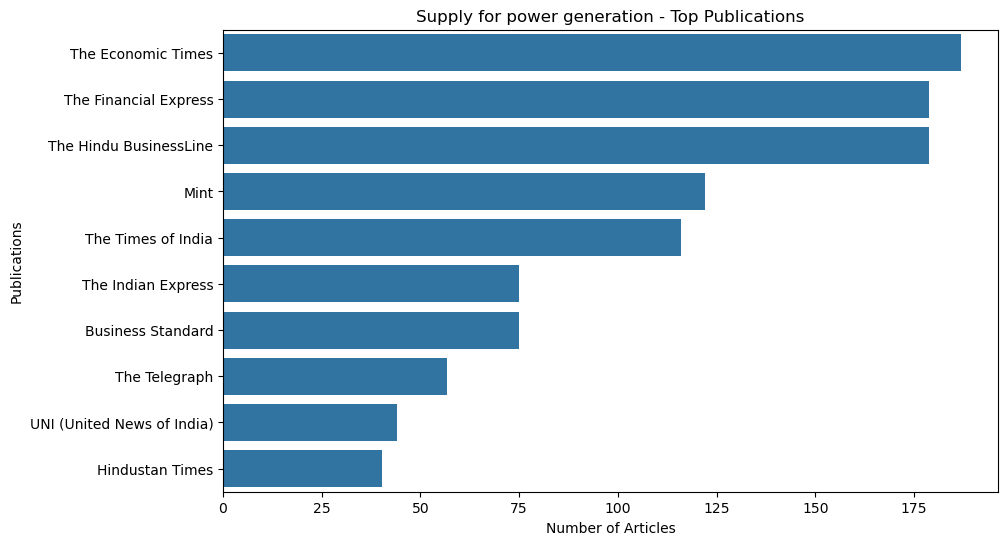

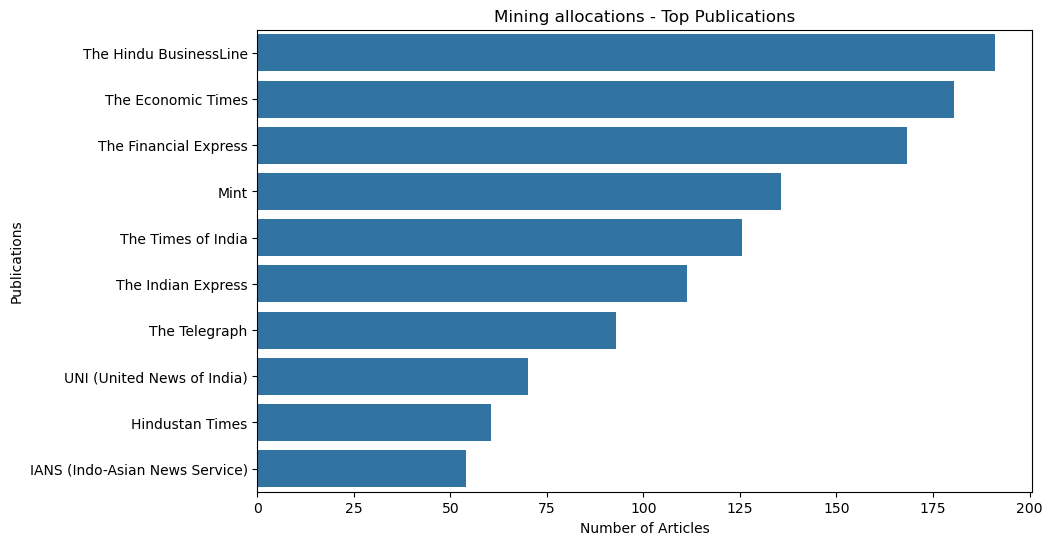

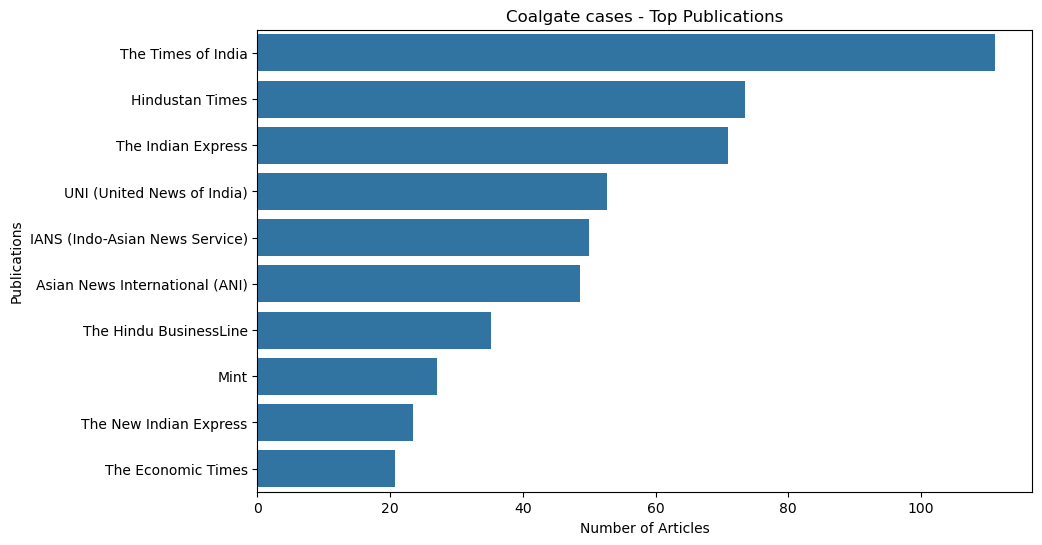

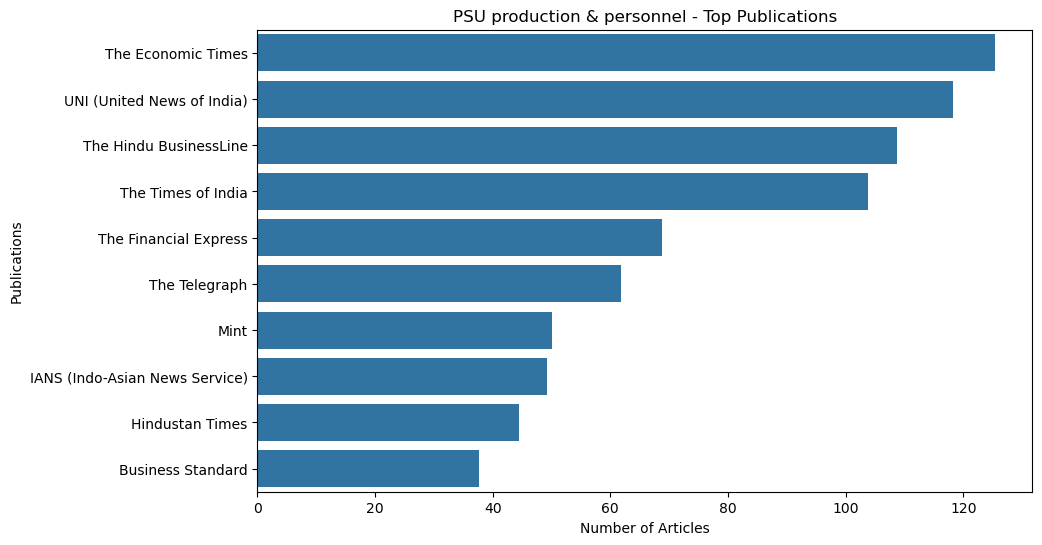

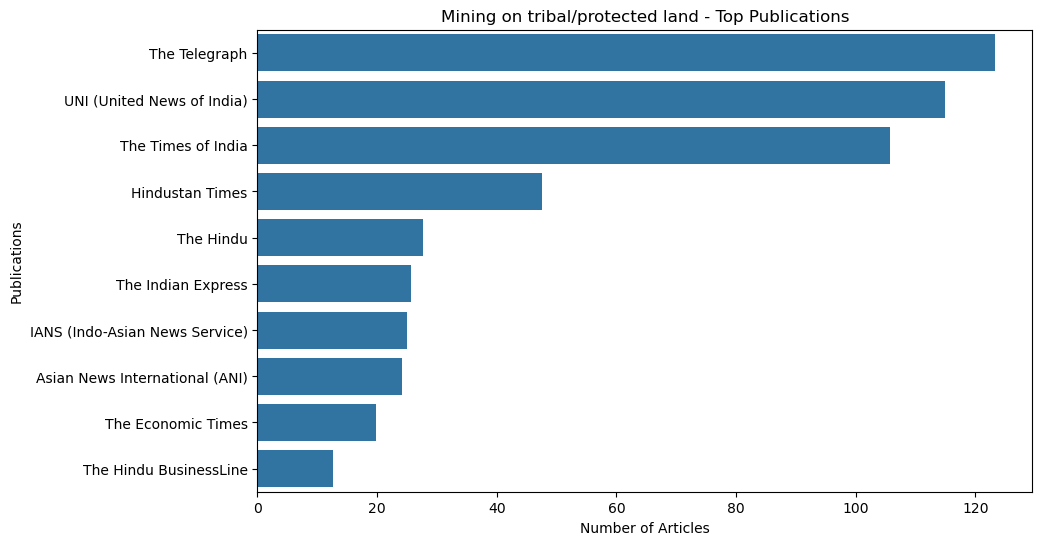

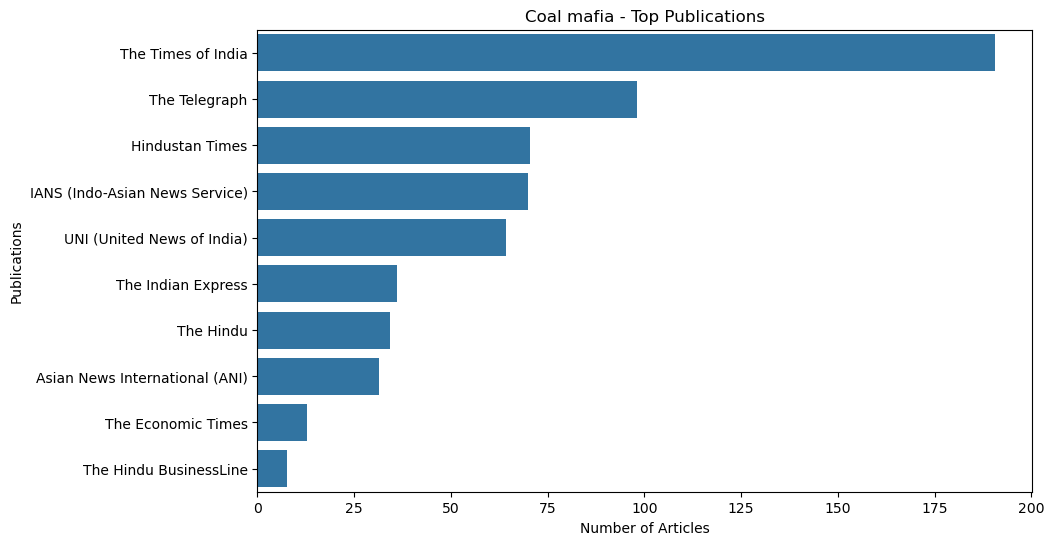

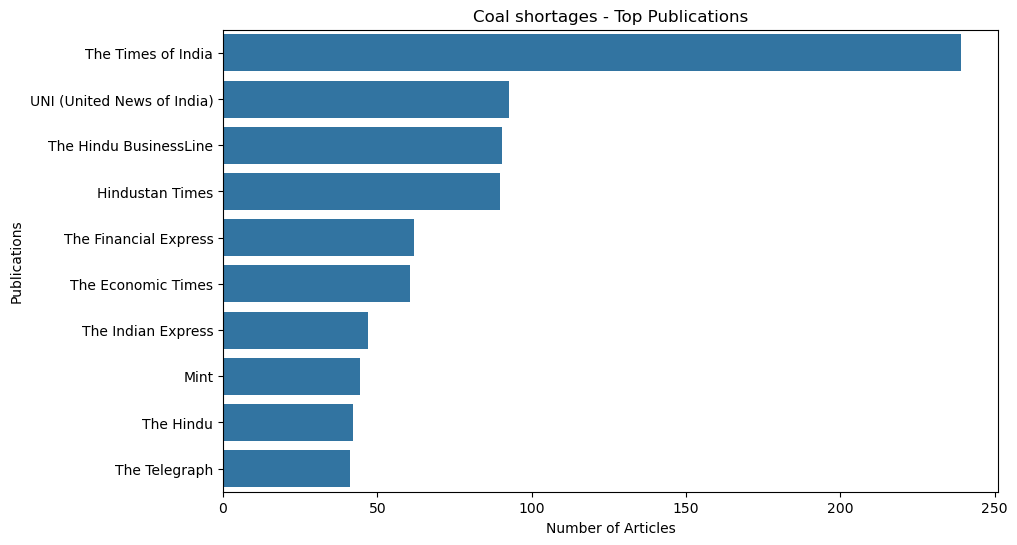

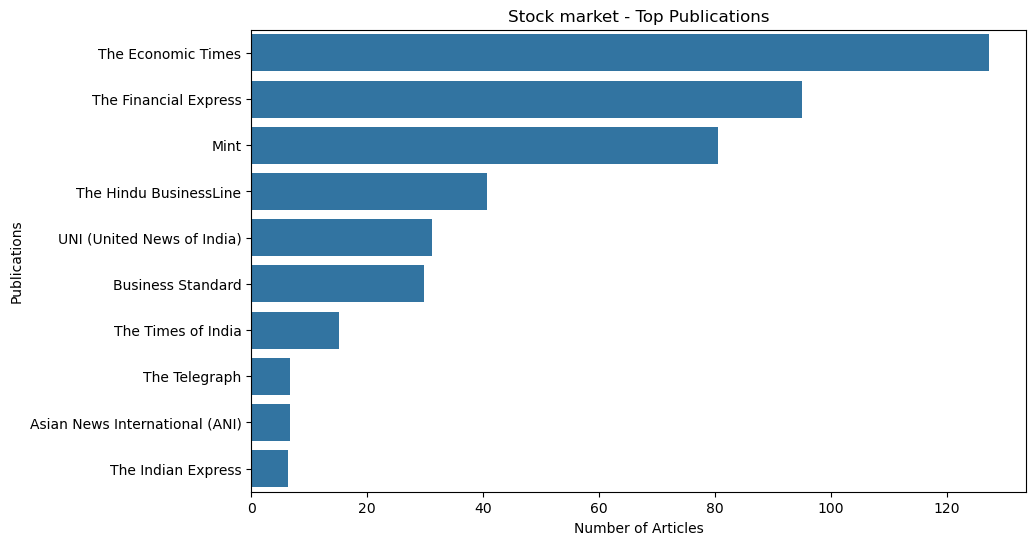

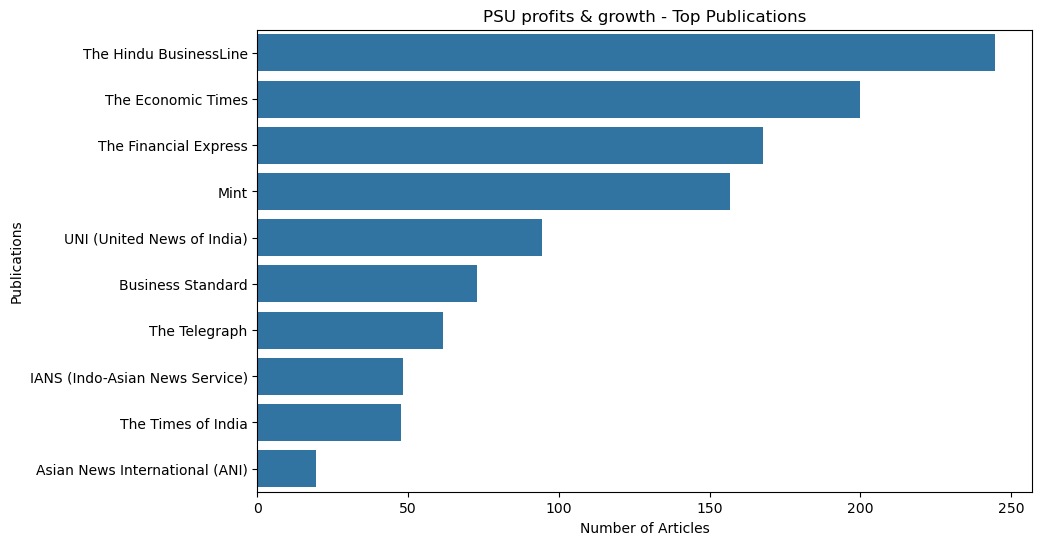

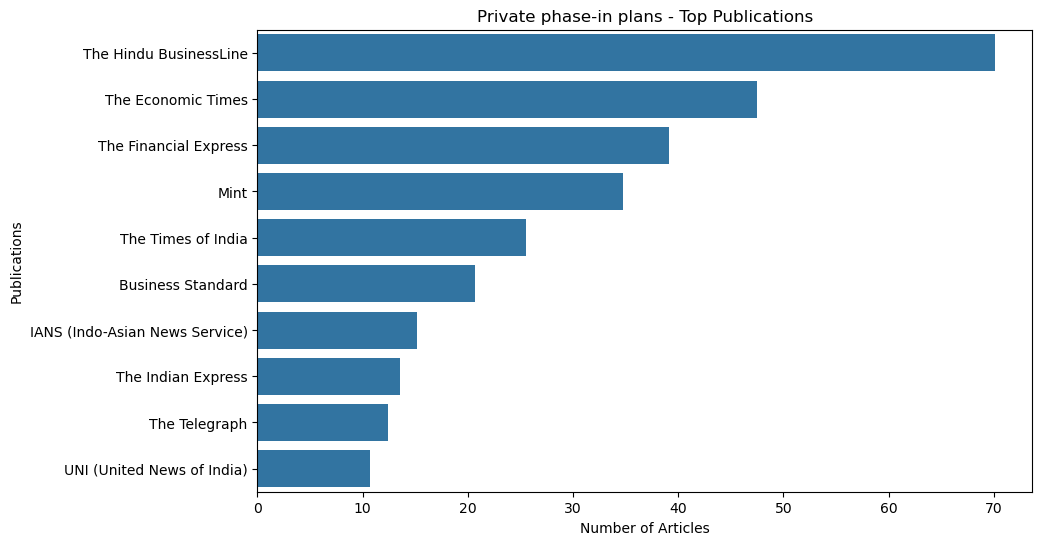

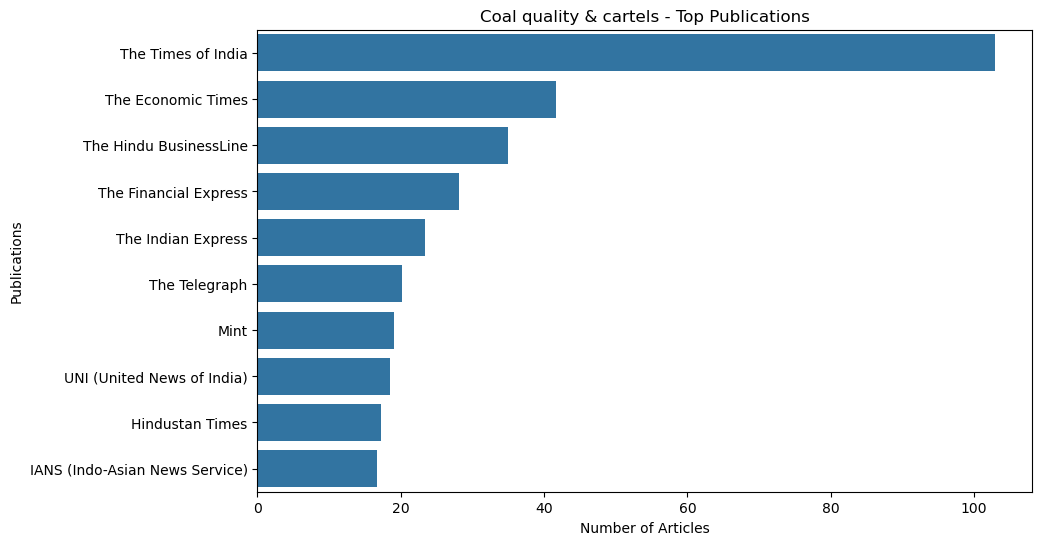

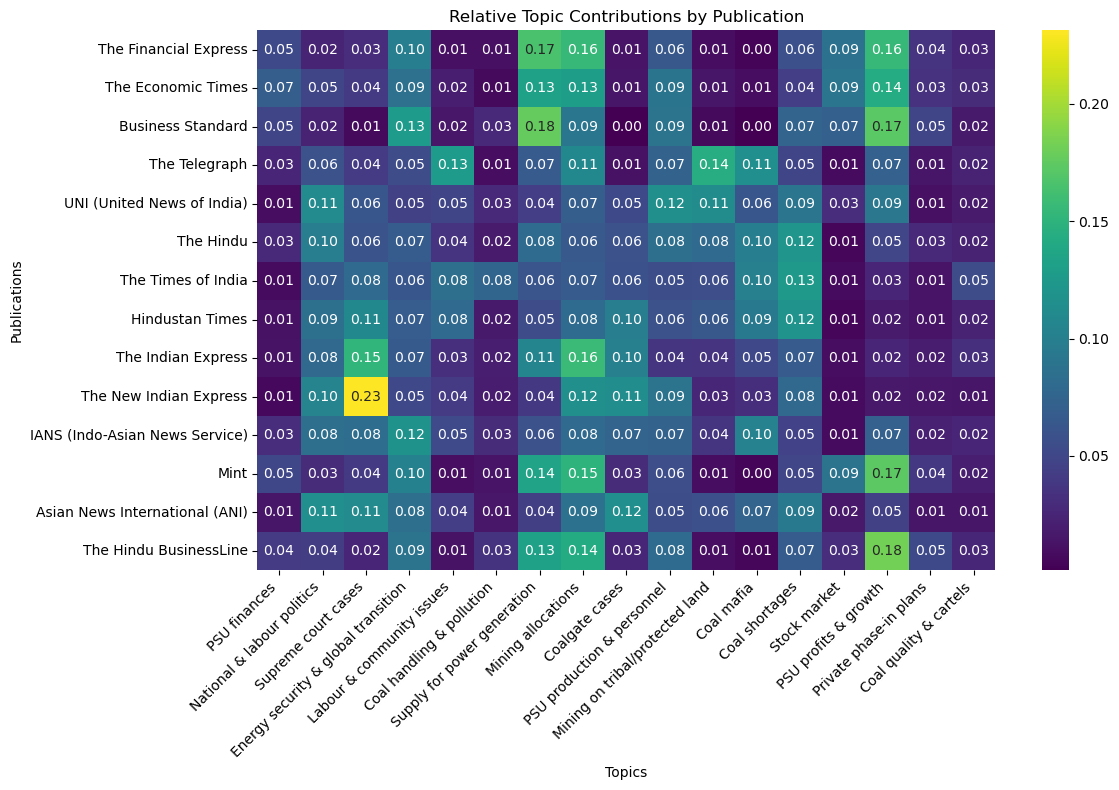

In [100]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# Load the model and dataset
with open('dtm_model5.pkl', 'rb') as file:
    model = pickle.load(file)
df = pd.read_csv('/mnt/c/Users/arnea/OneDrive/Desktop/Thesis/Work/Python/df_preprocessedv7.csv')
df['Date'] = pd.to_datetime(df['Date'])

# Topic names
topic_names = {
    0: "PSU finances",
    1: "National & labour politics",
    2: "Supreme court cases",
    3: "Energy security & global transition",
    4: "Labour & community issues",
    5: "Coal handling & pollution",
    6: "Supply for power generation",
    7: "Mining allocations",
    8: "Coalgate cases",
    9: "PSU production & personnel",
    10: "Mining on tribal/protected land",
    11: "Coal mafia",
    12: "Coal shortages",
    13: "Stock market",
    14: "PSU profits & growth",
    15: "Private phase-in plans",
    16: "Coal quality & cartels",
}

# Preparing the publication information and initializing the dataframe
publications = df['Publication'].unique()
topics = [topic_names[i] for i in range(model.gamma_.shape[1])]

# Initialize a DataFrame to store the contributions
topic_contributions = pd.DataFrame(0, index=publications, columns=topics)

# Sum up contributions for each publication
for i, pub in enumerate(df['Publication']):
    topic_contributions.loc[pub] += model.gamma_[i]

# Normalize the contributions to get relative contributions
topic_contributions_relative = topic_contributions.divide(topic_contributions.sum(axis=1), axis=0)

# Save to CSV
topic_contributions.to_csv('/mnt/c/Users/arnea/OneDrive/Desktop/Thesis/Work/Python/topic_contribution_by_publication.csv')
topic_contributions_relative.to_csv('/mnt/c/Users/arnea/OneDrive/Desktop/Thesis/Work/Python/relative_topic_contribution_by_publication.csv')

# Visualization: Bar Chart for each topic showing top publications
for topic in topics:
    plt.figure(figsize=(10, 6))
    top_pubs = topic_contributions[topic].sort_values(ascending=False).head(10)
    sns.barplot(x=top_pubs.values, y=top_pubs.index)
    plt.title(f'{topic} - Top Publications')
    plt.xlabel('Number of Articles')
    plt.ylabel('Publications')
    plt.show()

# Visualization: Heatmap of relative contributions
plt.figure(figsize=(12, 8))
sns.heatmap(topic_contributions_relative, annot=True, cmap='viridis', fmt=".2f")
plt.title('Relative Topic Contributions by Publication')
plt.xlabel('Topics')
plt.ylabel('Publications')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('/mnt/c/Users/arnea/OneDrive/Desktop/Thesis/Work/Python/publications_heatmap.png')
plt.show()

In [3]:
import numpy as np
import pickle
import pandas as pd

# Load the DTM model from disk
with open('dtm_model5.pkl', 'rb') as file:
    model = pickle.load(file)

df = pd.read_csv('/mnt/c/Users/arnea/OneDrive/Desktop/Thesis/Work/Python/df_preprocessedv7.csv')
df['Date'] = pd.to_datetime(df['Date'])

# Prepare timestamps for monthly time slices
df['YearMonth'] = df['Date'].dt.to_period('M')

# Filter data to only include dates up to October 2023
end_period = pd.Period('2023-10', freq='M')
filtered_df = df[df['YearMonth'] <= end_period]

time_slices = [filtered_df['YearMonth'].value_counts()[period] for period in sorted(filtered_df['YearMonth'].unique())]
dates = pd.date_range(start='2013-01-01', periods=len(time_slices), freq='MS')

num_topics = 17  # Set the number of topics
topic_shares_over_time = np.zeros((len(time_slices), num_topics))

# Populate the topic shares over time, accounting only for documents up to October 2023
doc_start_index = 0
max_index = len(model.gamma_)  # Maximum index for gamma_ matrix
for ts_index, num_docs in enumerate(time_slices):
    end_index = doc_start_index + num_docs
    if end_index > max_index:
        end_index = max_index
    for doc_index in range(doc_start_index, end_index):
        topic_shares_over_time[ts_index] += model.gamma_[doc_index, :]
    doc_start_index += num_docs
    if doc_start_index >= max_index:
        break  # Exit if we've processed all documents

topic_id = 3  # Index for "Energy security & global transition"
num_words = 10  # Top 10 words

# Extract the top words per year for the specified topic
top_words_per_year = {}
for year in range(2013, 2024):  # Adjust range to include 2023
    start_month = (year - 2013) * 12
    end_month = start_month + 12
    if year == 2023:  # Adjust for 2023 having data only up to October
        end_month = start_month + 10
    word_freqs = {}
    for month_index in range(start_month, end_month):
        if month_index < len(model.time_slices):
            topic_dist = model.show_topic(topic_id, time=month_index, num_words=num_words)
            for prob, word in topic_dist:
                if word not in word_freqs:
                    word_freqs[word] = 0
                word_freqs[word] += prob
    # Sort and select the top words
    sorted_words = sorted(word_freqs.items(), key=lambda x: x[1], reverse=True)[:num_words]
    top_words_per_year[year] = [word for word, _ in sorted_words]

# Convert the results to a DataFrame for easy viewing and saving
df_top_words = pd.DataFrame(top_words_per_year)
print("Top 10 Words per Year for 'Energy security & global transition':")
print(df_top_words)

# Save results to CSV
df_top_words.to_csv('/mnt/data/top_words_energy_security.csv', index=False)

/tmp/ipykernel_227/4274814690.py:13: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['YearMonth'] = df['Date'].dt.to_period('M')
/home/arne/miniconda3/envs/dtm2/lib/python3.8/site-packages/gensim/models/wrappers/dtmmodel.py:498: UserWarning: The parameter `num_words` is deprecated, will be removed in 4.0.0, use `topn` instead.
  warnings.warn("The parameter `num_words` is deprecated, will be removed in 4.0.0, use `topn` instead.")


Top 10 Words per Year for 'Energy security & global transition':
      2013      2014     2015       2016     2017     2018     2019     2020  \
0       ga        ga   energi     energi   energi   energi   energi   energi   
1  countri    energi  countri    countri    power    plant    plant    power   
2   sector   countri       ga      power    renew    power    renew    plant   
3     need      need  develop         ga  countri    renew    power    renew   
4  product    sector     need      renew    plant  countri  project  countri   
5     plan    govern    power    develop       ga  project  countri  project   
6   govern  industri   govern  technolog    capac       ga   global   global   
7      oil      plan    renew     govern    emiss   global    capac    capac   
8   polici   product     plan      solar    gener    capac   invest   invest   
9   privat      mine    solar        cbm  project   report    gener   sector   

      2021     2022     2023  
0   energi   energi   e

OSError: Cannot save file into a non-existent directory: '/mnt/data'